<div align="center">

**Differential Privacy : US Broadband Data**

**Trishita Patra**

</div>

Motivation: Protecting privacy while performing statistical analysis is quite challenging. On the one had,
the goal of statistics and machine learning is to be as informative as possible. Protecting privacy is the opposite goal.  

Can we protect privacy and still do an informative
analysis?

Dataset : [US Broadband Data](https://archive.ics.uci.edu/dataset/126/internet+usage+data)

#### Data Preprocessing

In [ ]:
'''
Uploading US Broadband dataset as zip file
'''
from google.colab import files
uploaded = files.upload()

Saving internet+usage+data.zip to internet+usage+data.zip


In [ ]:
'''
Etracting from zip file
'''
import zipfile
import os

zip_path = 'internet+usage+data.zip'
extract_path = '/content/extracted_folder'

with zipfile.ZipFile(zip_path,'r') as zip_ref:
  zip_ref.extractall(extract_path)

# list extracted files
for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))

/content/extracted_folder/final_general.dat.gz
/content/extracted_folder/internet_usage.html
/content/extracted_folder/internet_usage.data.html
/content/extracted_folder/changes
/content/extracted_folder/final_general.col


In [ ]:
'''
unzipping final_general.dat.gz
'''
import gzip
import shutil

# Define paths
gz_path = "/content/extracted_folder/final_general.dat.gz"
out_path = "/content/extracted_folder/final_general.dat"

# Unzip the file
with gzip.open(gz_path, 'rb') as f_in:
    with open(out_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Unzipped successfully.")

Unzipped successfully.


In [ ]:
# list extracted files
for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))

/content/extracted_folder/final_general.dat.gz
/content/extracted_folder/final_general.dat
/content/extracted_folder/internet_usage.html
/content/extracted_folder/internet_usage.data.html
/content/extracted_folder/changes
/content/extracted_folder/final_general.col


In [ ]:
'''
Creating dataframe from extracted fles
'''
import pandas as pd

col_file = '/content/extracted_folder/final_general.col'
dat_file = '/content/extracted_folder/final_general.dat'

# Read column file
with open(col_file,'r') as f:
  col_names = [line.strip() for line in f if line.strip()]

# Comparing number of column names and data dimension
print(f"Number of column names: {len(col_names)}")

with open(dat_file,'r') as f1:
    first_line = f1.readline().strip()
    print("Total fields in first row:", len(first_line.split()))

Number of column names: 70
Total fields in first row: 72


##### Need to address the mismatched column numbers.
- Checking if any column is duplicated.
  - Checking if each row has same number of attribute values!
- If not, eliminate 2 columns. Guesstimating which two might be the ones!



In [ ]:
'''
checking for duplicates!
Dictionary: key = number of attribute values present in the data
            value = number of data points(rows) with that many recorded attribute values!
'''
num_col_map = {}

# Read the .dat file manually and assign number of rows with respect to number of recorded attribute values
with open(dat_file,'r') as f:
    current_num = None
    for line in f:
      line = line.strip()
      x = len(line.split())
      if x not in num_col_map:
        num_col_map[x] = 1
      else:
        num_col_map[x] += 1

print(num_col_map)

{72: 7390, 71: 2676, 73: 37, 75: 1}


If each row has same number of recorded attribute values - no!

In [ ]:
total_rows = 0
for key in num_col_map:
    total_rows += num_col_map[key]
print("Total no. of data points :", total_rows )

percent_num_col = {}
for key in num_col_map:
  percent = 100*num_col_map[key]/total_rows # percentage
  percent_num_col[key] = f"{percent:.4f}"
print(percent_num_col)

Total no. of data points : 10104
{72: '73.1394', 71: '26.4846', 73: '0.3662', 75: '0.0099'}


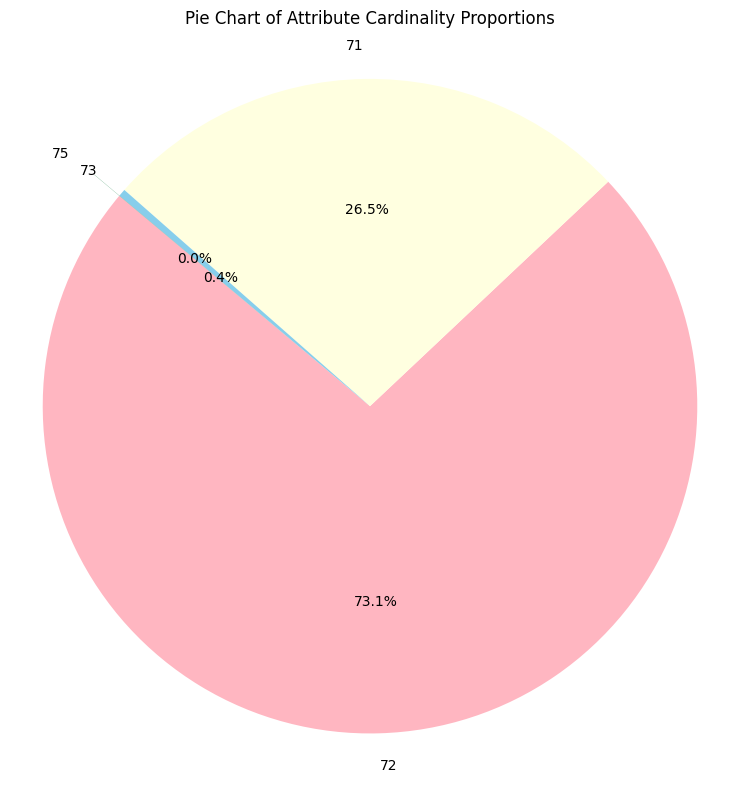

In [ ]:
import matplotlib.pyplot as plt

# Pie Chart

# Explode the smallest two slices
explode = [0.1 if value == min(num_col_map.values()) else 0 for value in num_col_map.values()]
colors = ['lightpink','lightyellow','skyblue', 'seagreen' ]

plt.figure(figsize=(7.5, 8))
plt.pie(
    num_col_map.values(),
    labels=num_col_map.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=colors, #plt.cm.Set3.colors,
    explode=explode
)
plt.title("Pie Chart of Attribute Cardinality Proportions")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()

In [ ]:
float(percent_num_col[73]) + float(percent_num_col[75])

0.37610000000000005

Since % of rows with recorded attribute values >72 values is very less (~ 0.3761%) and less likely to cause substantial loss in understanding the pattern/characteristics of the whole dataset, we eliminate these data points.

In [ ]:
expected_72 = 72
expected_71 = 71

rows_72 = []
rows_71 = []

# Read the file and filter rows by number of columns
with open(dat_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == expected_72:
            rows_72.append(parts)
        elif len(parts) == expected_71:
            rows_71.append(parts)

# Convert to DataFrames
df2 = pd.DataFrame(rows_72)
df1 = pd.DataFrame(rows_71)

print(f"df1 (71 columns): {df1.shape}")
print(f"df2 (72 columns): {df2.shape}")


df1 (71 columns): (2676, 71)
df2 (72 columns): (7390, 72)


In [ ]:
'''
Going back to metadata for help. Obtaing column embedding types (characteristic -> numerical) from change file.
'''
change_file = '/content/extracted_folder/changes'
col_value_map = {}

with open(change_file, 'r') as f:
    current_col = None
    for line in f:
        line = line.strip()
        if not line:
            continue
        elif '=' not in line:  # likely a new column embedding type
            current_col = line.rstrip(':')
            col_value_map[current_col] = 0
        elif current_col:  # collect values for current column
            col_value_map[current_col] += 1

# Show summary
for col, values in col_value_map.items():
    print(f"{col}: {values}" )

Universal:  (when applicable): 3
States: 124
Use of Internet: 5
Primary Language: 43
Access Internet: 7
Sexual Preference: 6
Who pays for internet access: 6
Registered to vote?: 4
Occupation type: 5
Education level: 9
Gender: 2
What they consider themselves: 10
Marital status: 7
Location: 12
Income: 9
Age: 3
Computer platform: 11
Using the Internet they've gained: 4
Issues facing internet: 9
Any question with yes/no answers: 3
Occupation: 45
Reason not willing to pay for access to site: 7
Providing personal information: 7


In [ ]:
# Check for duplicated columns using default indices
# transposing since it works for rows
duplicated_cols_mask1 = df1.T.duplicated()
duplicated_cols_mask2 = df2.T.duplicated()

# Get indices of duplicated columns
duplicate_col_indices1 = [i for i, is_dup in enumerate(duplicated_cols_mask1) if is_dup]
duplicate_col_indices2 = [i for i, is_dup in enumerate(duplicated_cols_mask2) if is_dup]

print("Indices of duplicate columns in df1:",duplicate_col_indices1)
print("Indices of duplicate columns in df2:", duplicate_col_indices2)

#print(duplicated_cols_mask1)


Indices of duplicate columns in df1: []
Indices of duplicate columns in df2: []


No column is duplicated when looked at df1, and df2 separately.

##### Guesstimating missing attribute names:

In [ ]:
# Create dictionaries for cardinality of columns in df1 and df2
def calculate_cardinality(df):
    cardinality_dict = {}

    # Iterate over each column in the dataframe
    for col_index, col in enumerate(df.columns):
        cardinality = df[col].nunique()  # Get the number of unique values in the column

        # Add the column index to the dictionary based on the cardinality
        if cardinality not in cardinality_dict:
            cardinality_dict[cardinality] = []

        cardinality_dict[cardinality].append(col_index)

    return cardinality_dict

# Calculate cardinality for df1 and df2
cardinality_df1 = calculate_cardinality(df1)
cardinality_df2 = calculate_cardinality(df2)

# Display cardinality dictionaries for both dataframes
print("Cardinality of columns in df1:")
print(cardinality_df1, "\n Number of datapoints :", df1.shape[0], "\n Maximum Column Cardinality :", max(cardinality_df1))

print("\nCardinality of columns in df2:")
print(cardinality_df2,"\n Number of datapoints :", df2.shape[0], "\n Maximum Column Cardinality :", max(cardinality_df2))


Cardinality of columns in df1:
{41: [0], 75: [1], 4: [2, 35, 58], 2: [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67], 54: [11], 9: [18, 21, 34], 7: [19, 33, 68], 6: [31, 59], 5: [32, 69], 23: [36], 8: [37, 38], 3: [60, 61], 2676: [70]} 
 Number of datapoints : 2676 
 Maximum Column Cardinality : 2676

Cardinality of columns in df2:
{43: [0], 77: [1], 13: [2], 4: [3, 59], 2: [4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 23, 24, 25, 27, 28, 29, 30, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 63, 64, 65, 66, 67, 68], 119: [11], 14: [12], 9: [18, 21, 34], 8: [19, 22, 33, 38, 39], 5: [20, 70], 3: [26, 61, 62], 10: [31], 6: [32, 35, 60], 11: [36], 52: [37], 7: [69], 7390: [71]} 
 Number of datapoints : 7390 
 Maximum Column Cardinality : 7390


From the number of datapoints in each table and maximum column cardinality, it is evident that each table has a column which assigns unique IDs to data points!

In [ ]:
max_card = max(col_value_map.values())
print("According to 'changes' file, characteristic attribute value to numerical value conversion, can result in atmost", max_card, "cardinality column.")

According to 'changes' file, characteristic attribute value to numerical value conversion, can result in atmost 124 cardinality column.


In [ ]:
'''
Obtaining column cardinalities of interest
'''
def card_int(df, dict_card, max_card):
  card_q =[]
  for val in dict_card.keys():
    if val > max_card:
      card_q.append(val)
  return card_q

card1 = card_int(df1,cardinality_df1, max_card)
card2 = card_int(df2,cardinality_df2, max_card)

print(card1)
print(card2)

[2676]
[7390]


In [ ]:
print("Column index with uinque ID:")
print("df1 :",cardinality_df1[2676], "\nwhile #columns in df1 :", df1.shape[1])
print("df2 :", cardinality_df2[7390], "\nwhile #columns in df2 :", df2.shape[1])

Column index with uinque ID:
df1 : [70] 
while #columns in df1 : 71
df2 : [71] 
while #columns in df2 : 72


Hence we conclude the last column in unique ID, which we add to column names!

In [ ]:
col_names.append('Unique ID')

In [ ]:
# Compute how many columns in df1 have each cardinality
card_df1 = {key: len(cardinality_df1[key]) for key in cardinality_df1}

# Compute how many columns in df2 have each cardinality
card_df2 = {key: len(cardinality_df2[key]) for key in cardinality_df2}

# Print results
print("Count of columns with each cardinality in df1:")
print(card_df1)

print("\nCount of columns with each cardinality in df2:")
print(card_df2)


Count of columns with each cardinality in df1:
{41: 1, 75: 1, 4: 3, 2: 49, 54: 1, 9: 3, 7: 3, 6: 2, 5: 2, 23: 1, 8: 2, 3: 2, 2676: 1}

Count of columns with each cardinality in df2:
{43: 1, 77: 1, 13: 1, 4: 2, 2: 44, 119: 1, 14: 1, 9: 3, 8: 5, 5: 2, 3: 3, 10: 1, 6: 3, 11: 1, 52: 1, 7: 1, 7390: 1}


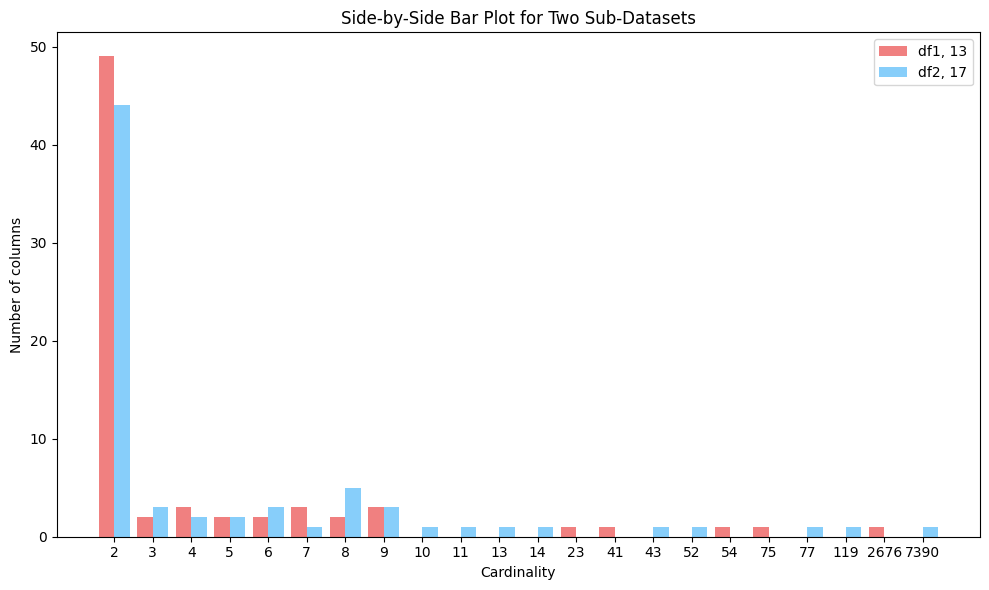

In [ ]:
# Union of all unique x labels
import numpy as np

x1 = card_df1.keys()
x2 = card_df2.keys()
y1 = card_df1.values()
y2 = card_df2.values()

all_labels = sorted(set(x1) | set(x2))
x_pos = np.arange(len(all_labels))

# Create lookup dicts for values
y1_dict = dict(zip(x1, y1))
y2_dict = dict(zip(x2, y2))

# Align y-values to the same order
y1_aligned = [y1_dict.get(label, 0) for label in all_labels]
y2_aligned = [y2_dict.get(label, 0) for label in all_labels]

# Bar width and offsets
width = 0.4

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x_pos - width/2, y1_aligned, width, label=f'df1, {len(x1)}', color='lightcoral')
plt.bar(x_pos + width/2, y2_aligned, width, label=f'df2, {len(x2)}', color='lightskyblue')

plt.xticks(x_pos, all_labels)
plt.xlabel("Cardinality")
plt.ylabel("Number of columns")
plt.title("Side-by-Side Bar Plot for Two Sub-Datasets")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
x = sorted(col_value_map.values())  # column conversion output cardinality as given in 'changes'

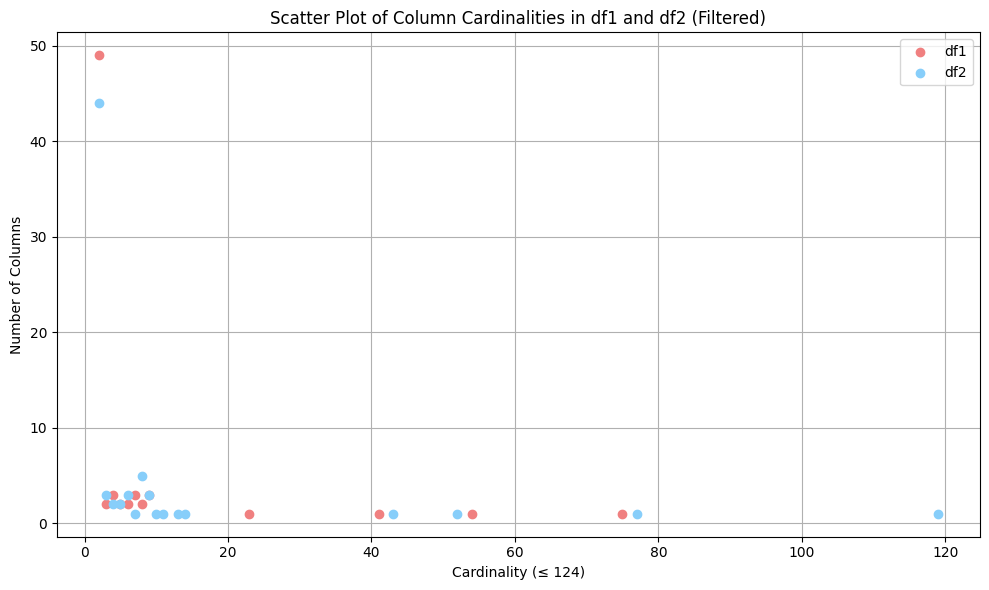

In [ ]:
# Plotting | scatter, eliminating column cardinality > max_card = 124, since they already has been dealt with, and they were affecting range

# Filter df1 points
x1_filtered = [x for x, y in zip(x1, y1) if x <= max_card]
y1_filtered = [y for x, y in zip(x1, y1) if x <= max_card]

# Filter df2 points
x2_filtered = [x for x, y in zip(x2, y2) if x <= max_card]
y2_filtered = [y for x, y in zip(x2, y2) if x <= max_card]

plt.figure(figsize=(10, 6))

plt.scatter(x1_filtered, y1_filtered, color='lightcoral', label='df1')
plt.scatter(x2_filtered, y2_filtered, color='lightskyblue', label='df2')

plt.xlabel("Cardinality (≤ 124)")
plt.ylabel("Number of Columns")
plt.title("Scatter Plot of Column Cardinalities in df1 and df2 (Filtered)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Time for guesstimate!
The BIG Assumptions:
- With respectt to df2, df1 has missing values from a single column only.
- The underlying cause of the missing values do not affect other attributes. i.e. if Column A is taking n many values in df1, it is taking ~n (almost n many) values in df2 as well.

Now see that there are total five column cardinality $> 45$, but $< 124$. With our assumption, it is reasonable that following two column cardinality pairs in (df1,df2) correspond to same recorded attribute.
- (54,52)
- (75,77)

column cardinality 119 (which has to be states) in df2 is the unknown one!

In [ ]:
'''
looking for conversion type of card. 124
'''
for item in col_value_map:
  if col_value_map[item] == 124:
    print(item)

States


In [ ]:
print("Guesstimated unknown column in df2 :",cardinality_df2[119])

Guesstimated unknown column in df2 : [11]


In [ ]:
df2 = df2.drop(df2.columns[11], axis=1)


Now...finally, we have sub datasets with matching dimensionality!  

In [ ]:
valid_rows = []

with open(dat_file, 'r') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == 72:
            # Remove the 12th value (index 11)
            values.pop(11)
            valid_rows.append(values)
        elif len(values) > 72:
            continue  # rows more than 72 columns are dropped
        else:
            valid_rows.append(values) # 71 perfect!

# Create DataFrame
df = pd.DataFrame(valid_rows, columns=col_names)

print(df.shape)
df.head()

(10066, 71)


,Actual Time,Age,Community Building,Community Membership_Family,Community Membership_Hobbies,Community Membership_None,Community Membership_Other,Community Membership_Political,Community Membership_Professional,Community Membership_Religious,...,Web Page Creation,Who Pays for Access_Don't Know,Who Pays for Access_Other,Who Pays for Access_Parents,Who Pays for Access_School,Who Pays for Access_Self,Who Pays for Access_Work,Willingness to Pay Fees,Years on Internet,Unique ID
0,5,41,2,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,99,2,93819
1,2,28,2,0,0,0,0,0,0,0,...,2,0,0,0,0,1,0,4,0,95708
2,99,25,0,1,1,0,0,0,1,0,...,1,0,0,0,0,1,1,99,2,97218
3,29,28,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,4,2,91627
4,15,17,0,0,0,0,0,1,1,0,...,1,0,0,0,0,1,0,4,2,49906


In [ ]:
col_names

['Actual Time',
 'Age',
 'Community Building',
 'Community Membership_Family',
 'Community Membership_Hobbies',
 'Community Membership_None',
 'Community Membership_Other',
 'Community Membership_Political',
 'Community Membership_Professional',
 'Community Membership_Religious',
 'Community Membership_Support',
 'Country\tDisability_Cognitive',
 'Disability_Hearing',
 'Disability_Motor',
 'Disability_Not Impaired',
 'Disability_Not Say',
 'Disability_Vision',
 'Education Attainment',
 'Falsification of Information',
 'Gender',
 'Household Income',
 'How You Heard About Survey_Banner',
 'How You Heard About Survey_Friend',
 'How You Heard About Survey_Mailing List',
 'How You Heard About Survey_Others',
 'How You Heard About Survey_Printed Media',
 'How You Heard About Survey_Remebered',
 'How You Heard About Survey_Search Engine',
 'How You Heard About Survey_Usenet News',
 'How You Heard About Survey_WWW Page',
 'Major Geographical Location',
 'Major Occupation',
 'Marital Status',
 

In [ ]:
'''
Column Cardinality  to looka t attributes
'''
fin = {}
cardinality_df = calculate_cardinality(df)
for cardinality, indices in cardinality_df.items():
    for idx in indices:
      fin[col_names[idx]] = cardinality
      print(f"{col_names[idx]}: {cardinality}")

Actual Time: 43
Age: 78
Community Building: 13
Community Membership_Family: 4
Registered to Vote: 4
Community Membership_Hobbies: 2
Community Membership_None: 2
Community Membership_Other: 2
Community Membership_Political: 2
Community Membership_Professional: 2
Community Membership_Religious: 2
Community Membership_Support: 2
Disability_Hearing: 2
Disability_Motor: 2
Disability_Not Impaired: 2
Disability_Not Say: 2
Disability_Vision: 2
How You Heard About Survey_Friend: 2
How You Heard About Survey_Mailing List: 2
How You Heard About Survey_Others: 2
How You Heard About Survey_Remebered: 2
How You Heard About Survey_Search Engine: 2
How You Heard About Survey_Usenet News: 2
How You Heard About Survey_WWW Page: 2
Not Purchasing_Bad experience: 2
Not Purchasing_Bad press: 2
Not Purchasing_Cant find: 2
Not Purchasing_Company policy: 2
Not Purchasing_Easier locally: 2
Not Purchasing_Enough info: 2
Not Purchasing_Judge quality: 2
Not Purchasing_Never tried: 2
Not Purchasing_No credit: 2
Not

#### Differential Privacy

 This dataset is well-suited for a differential privacy project given its demographic richness and potential privacy concerns.

Differential privacy anonymizes data by randomizing
sensitive information but in a way that regardless of
whether an individual record is included in the data set
or not, the outcome of statistical queries remains
approximately the same. Differential privacy provides
formal statistical privacy guarantees.

Differential privacy mathematically guarantees that anyone seeing the
result of a differentially private analysis will essentially make the same
inference about any individual’s private information, whether or not that
individual’s private information is included in the input to the analysis.
- It works by adding noise to the sensitive
values to protect privacy, while maximizing the accuracy
of queries.
- Domain knowledge helps us to predict which queries might be executed on the dataset.

- Direct identifiers, like 'Unique ID' has to be removed.
- **Randomized response** is a method that modifies the value of
each item in a data set according to certain probabilistic rules.
- Adding noise.

Based on domain Knowledge and column cardinality, we determine
- PII (Personally Identifiable Information) : Attributes that can uniquely or directly identify an individual.
- Quasi-Identifiers (QI) : Attributes that don’t identify directly but can be combined to do so.
- Sensitive Attributes : Attributes a user would consider private or are policy-sensitive.


### **1. Direct Identifiers (PII)**
These columns should be **removed or heavily anonymized** since they can directly identify individuals.

| Column Number | Column Name               | Cardinality | Action                     | Reasoning                                                                 |
|--------------|--------------------------|------------|----------------------------|---------------------------------------------------------------------------|
| 70           | Unique ID                | 10066      | Remove entirely            | Unique per row, directly identifies individuals.                          |
---

### **2. Quasi-Identifiers**
These columns should be **generalized or bucketed** to prevent re-identification via linkage attacks.

| Column Number | Column Name                     | Cardinality | Action                                 | Reasoning                                                                 |
|--------------|--------------------------------|------------|----------------------------------------|---------------------------------------------------------------------------|
| 0            | Actual Time              | 43         | Remove or bucket into days | Timestamps can be identifying when combined with other data.              |
| -            | Gender              | -         | - | Even with low cardinality, while combined with age, race  and others, can reidentify the individual.             |
| 11           | Country                  | 54         | Generalize to region       | High cardinality; may re-identify when combined with other quasi-IDs.     |
| 1            | Age                            | 78         | Bucket into ranges (e.g., 0-18, 19-25)| Exact age is highly identifying.                                          |
| 36           | Race                           | 56         | Group rare races into "Other"         | High cardinality; rare combinations risk re-identification.               |
| 17           | Education Attainment           | 9          | Merge similar levels                  |                             |
| 2            | Community Building             | 13         | Bucket into broader categories        | Reduces granularity.                                                      |
| 31, 32, 37, 38 | Major Occupation / Location   | 8          | Generalize (e.g., "Tech" → "STEM")    | Occupations/locations can be identifying.                                 |

---

### **3. Sensitive Information**
These columns should be protected via **noise addition (Laplace/Exponential mechanisms)** or **suppression** to avoid privacy leaks.

| Column Number(s) | Column Name(s)                          | Cardinality | DP Mechanism                                                                 | Reasoning                                                                 |
|------------------|----------------------------------------|-------------|------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| 11–16            | Disability_* (Cognitive, Hearing, etc.) | -          | Laplace noise to counts (e.g., "Yes/No" responses)                           | Health data is highly sensitive; small counts risk re-identification.     |
| ?                | Sexual Preference                      | ?           | -         | Highly personal; rare values (e.g., LGBTQ+ identities) need protection.   |
| ?                | Marital Status                         | ?           | Bucket into broader categories (e.g., "Single/Partnered")                   | Sensitive in some cultural contexts.                                      |
| ?                | Opinions on Censorship                 | ?           | Add noise to aggregated counts (e.g., "Support/Neutral/Oppose" proportions)  | Political opinions can be risky if linked to identity.                   |
| ?                | Falsification of Information           | ?           | Suppress or add noise to "Yes" responses                                    | Admitting to falsifying data is sensitive.                                |
| ?                | Household Income                       | ?           | Bucket into ranges (e.g., "$0–30K", "$30–60K") + Laplace noise             | Income is both sensitive and a quasi-identifier.                          |

---

### **4. Non-Sensitive Attributes**
These columns can typically **remain as-is** but should be checked for rare combinations that could act as quasi-identifiers.

| Column Number(s) | Column Name(s)                          | Cardinality | Action                           | Reasoning                                                                 |
|------------------|----------------------------------------|-------------|----------------------------------|---------------------------------------------------------------------------|
| 3–10             | Community Membership_* (Family, Hobbies, etc.) | 2–4       | No change (unless rare combinations exist) | Behavioral data; low risk if not combined with quasi-IDs.                 |
| 22–29            | How You Heard About Survey_*           | 2–4        | No change                        | Marketing-related; non-sensitive.                                         |
| ?                | Web Ordering / Web Page Creation       | 2           | No change                        | Binary behavioral data; non-sensitive.                                    |
| 19, 68           | Primary Computing Platform / Language  | 7           | No change (or group rare languages) | Low risk unless platform/language is rare (e.g., "BSD Unix" users).      |
| -             | Not Purchasing_* | -       | No change (unless rare combinations exist) | Behavioral data; low risk if not combined with quasi-IDs.                 |

---

### Actions to Apply:

| Category           | Action                                                                                                |
| ------------------ | ----------------------------------------------------------------------------------------------------- |
| **PII**            | Remove (e.g., `Unique ID`)                                                                            |
| **QI**             | Apply **k-anonymity** or **ℓ-diversity** (e.g., group ages, reduce location resolution) to reduce re-identification risk.
| **Sensitive**      | Add noise using **differential privacy** (e.g., Laplace/Gaussian)          |
| **Doesn’t Matter** | Can keep as-is                                                                      


In our dataset, every column has been categorized. We focus on DP - Laplacian mechanism.

Something stupid, from manual labelling:

In [ ]:
fin_at = {
    'Actual Time': (43, 'QI'),
    'Age': (78, 'QI'),
    'Community Building': (13, 'QI'),
    'Community Membership_Family': (4, 'NSA'),
    'Registered to Vote': (4, 'NSA'),
    'Community Membership_Hobbies': (2, 'NSA'),
    'Community Membership_None': (2, 'NSA'),
    'Community Membership_Other': (2, 'NSA'),
    'Community Membership_Political': (2, 'NSA'),
    'Community Membership_Professional': (2, 'NSA'),
    'Community Membership_Religious': (2, 'NSA'),
    'Community Membership_Support': (2, 'NSA'),
    'Disability_Hearing': (2, 'SA'),
    'Disability_Motor': (2, 'SA'),
    'Disability_Not Impaired': (2, 'NSA'),
    'Disability_Not Say': (2, 'SA'),
    'Disability_Vision': (2, 'SA'),
    'How You Heard About Survey_Friend': (2, 'NSA'),
    'How You Heard About Survey_Mailing List': (2, 'NSA'),
    'How You Heard About Survey_Others': (2, 'NSA'),
    'How You Heard About Survey_Remebered': (2, 'NSA'),
    'How You Heard About Survey_Search Engine': (2, 'NSA'),
    'How You Heard About Survey_Usenet News': (2, 'NSA'),
    'How You Heard About Survey_WWW Page': (2, 'NSA'),
    'Not Purchasing_Bad experience': (2, 'NSA'),
    'Not Purchasing_Bad press': (2, 'NSA'),
    'Not Purchasing_Cant find': (2, 'NSA'),
    'Not Purchasing_Company policy': (2, 'NSA'),
    'Not Purchasing_Easier locally': (2, 'NSA'),
    'Not Purchasing_Enough info': (2, 'NSA'),
    'Not Purchasing_Judge quality': (2, 'NSA'),
    'Not Purchasing_Never tried': (2, 'NSA'),
    'Not Purchasing_No credit': (2, 'NSA'),
    'Not Purchasing_Not applicable': (2, 'NSA'),
    'Not Purchasing_Not option': (2, 'NSA'),
    'Not Purchasing_Other': (2, 'NSA'),
    'Not Purchasing_Prefer people': (2, 'NSA'),
    'Not Purchasing_Privacy': (2, 'NSA'),
    'Not Purchasing_Receipt': (2, 'NSA'),
    'Not Purchasing_Security': (2, 'NSA'),
    'Not Purchasing_Too complicated': (2, 'NSA'),
    'Not Purchasing_Uncomfortable': (2, 'NSA'),
    'Not Purchasing_Unfamiliar vendor': (2, 'NSA'),
    "Who Pays for Access_Don't Know": (2, 'NSA'),
    'Who Pays for Access_Other': (2, 'NSA'),
    'Who Pays for Access_Parents': (2, 'NSA'),
    'Who Pays for Access_School': (2, 'NSA'),
    'Who Pays for Access_Self': (2, 'NSA'),
    'Who Pays for Access_Work': (2, 'NSA'),
    'Country\tDisability_Cognitive': (54, 'SA'),
    'Education Attainment': (9, 'QI'),
    'Falsification of Information': (9, 'SA'),
    'Household Income': (9, 'SA'),
    'How You Heard About Survey_Banner': (9, 'NSA'),
    'Most Import Issue Facing the Internet': (9, 'SA'),
    'Opinions on Censorship': (9, 'SA'),
    'Gender': (7, 'QI'),
    'Willingness to Pay Fees': (7, 'NSA'),
    'How You Heard About Survey_Printed Media': (3, 'NSA'),
    'Web Ordering': (3, 'NSA'),
    'Web Page Creation': (3, 'NSA'),
    'Major Geographical Location': (10, 'QI'),
    'Major Occupation': (8, 'QI'),
    'Marital Status': (8, 'SA'),
    'Primary Place of WWW Access': (8, 'QI'),
    'Race': (8, 'QI'),
    'Primary Computing Platform': (11, 'QI'),
    'Primary Language': (56, 'QI'),
    'Sexual Preference': (6, 'SA'),
    'Years on Internet': (5, 'QI'),
    'Unique ID': (10066, 'PII')
}


Visualization of Attribute cardinality coloured by type. (Excluding PII, for high cardinality)

<ipython-input-29-6465c9dbdbf5>:50: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


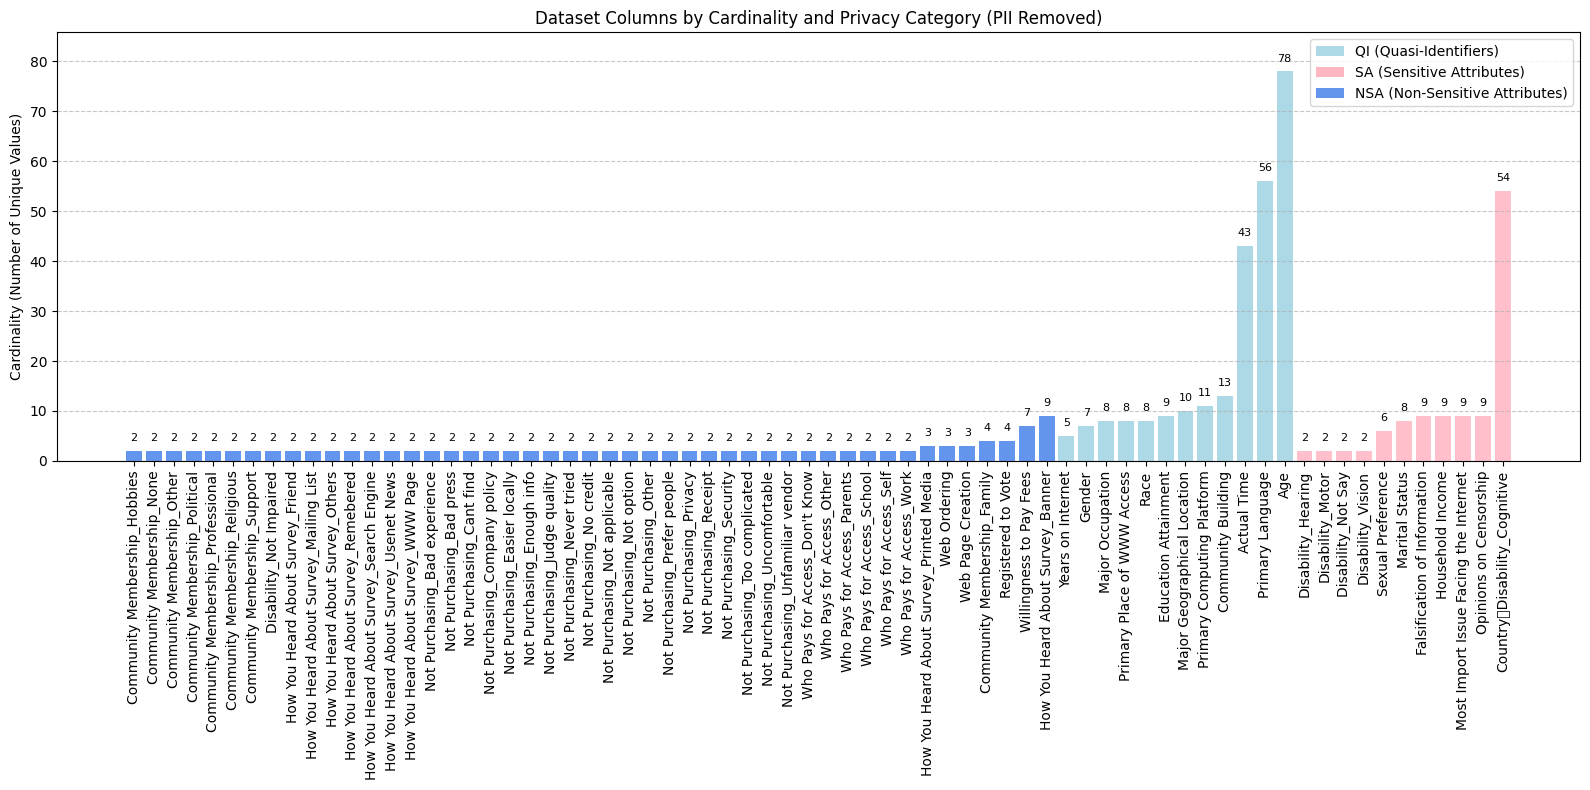

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Filter out PII entries
filtered_data = {k: v for k, v in fin_at.items() if v[1] != 'PII'}

# Sort by category (value[1]) then by cardinality (value[0])
sorted_items = sorted(filtered_data.items(), key=lambda x: (x[1][1], x[1][0]))

# Extract data for plotting
labels = [item[0] for item in sorted_items]
cardinalities = [item[1][0] for item in sorted_items]
categories = [item[1][1] for item in sorted_items]

# Create color mapping
color_map = {
    'QI': 'lightblue',
    'SA': 'pink',
    'NSA': 'cornflowerblue'
}
colors = [color_map[cat] for cat in categories]

# Create the plot with vertical bars
plt.figure(figsize=(16, 8))
bars = plt.bar(labels, cardinalities, color=colors)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='center')

# Add text labels for cardinality above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02*max(cardinalities),
             f'{int(height)}', ha='center', va='bottom', rotation=0, fontsize=8)

# Customize the plot
plt.ylabel('Cardinality (Number of Unique Values)')
plt.title('Dataset Columns by Cardinality and Privacy Category (PII Removed)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.margins(y=0.1)  # Add some margin at the top for the labels

# Create legend
legend_elements = [
    Patch(facecolor='lightblue', label='QI (Quasi-Identifiers)'),
    Patch(facecolor='lightpink', label='SA (Sensitive Attributes)'),
    Patch(facecolor='cornflowerblue', label='NSA (Non-Sensitive Attributes)')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Initialize counters
counts = {'PII': 0, 'QI': 0, 'SA': 0, 'NSA': 0}

# Count each category
for key, value in fin_at.items():
    category = value[1]  # The second element of the tuple is the category
    counts[category] += 1

total = sum(counts.values())
print("\nNumber of columns in each category:")
for category, count in counts.items():
    print(f"{category}: {count} columns - {count/total:.1%}")


Number of columns in each category:
PII: 1 columns - 1.4%
QI: 12 columns - 16.9%
SA: 11 columns - 15.5%
NSA: 47 columns - 66.2%


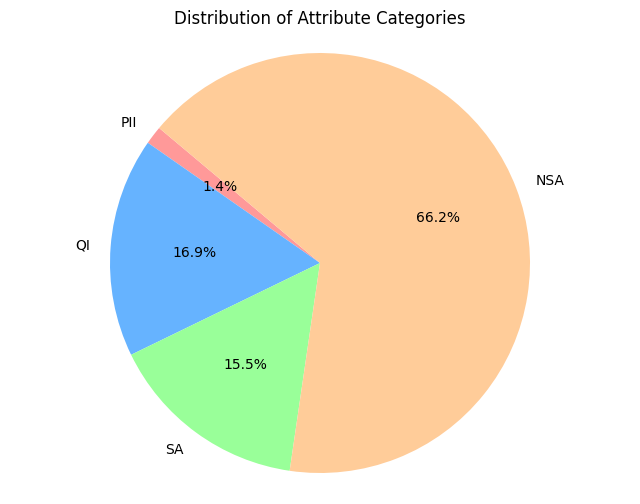

In [ ]:
# Pie chart setup | Visualizing the attribute types
labels = counts.keys()
sizes = counts.values()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']  # Custom colors
#explode = [0.05 if count == max(sizes) else 0 for count in sizes]  # Explode largest slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
#plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=140)
plt.title("Distribution of Attribute Categories")
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

In [ ]:
sensitive_columns = [k for k, v in fin_at.items() if v[1] == 'SA']
print(f"The {len(sensitive_columns)} sensitive attributes are : {sensitive_columns}")

The 11 sensitive attributes are : ['Disability_Hearing', 'Disability_Motor', 'Disability_Not Say', 'Disability_Vision', 'Country\tDisability_Cognitive', 'Falsification of Information', 'Household Income', 'Most Import Issue Facing the Internet', 'Opinions on Censorship', 'Marital Status', 'Sexual Preference']


### 1. Why This Choice of p and q Guarantees ε-DP

### Differential Privacy Proof for Randomized Response

For any two values x and y in the domain:

    Pr[Output = x | True = x] / Pr[Output = x | True = y] = p / q ≤ e^ε

Where:
- p is the probability of reporting the true value
- q is the probability of reporting any other fixed value

Given:
- p = e^ε / (e^ε + k - 1)
- q = 1 / (e^ε + k - 1)

Then:

    p / q = (e^ε / (e^ε + k - 1)) / (1 / (e^ε + k - 1)) = e^ε

This satisfies the DP definition because the worst-case ratio is exactly \( e^eps \).

---

### 2. Intuition Behind the Formula

**A. The Privacy Budget (ε):**
- When ε → 0: \( p -> 1/k) (complete randomness, maximal privacy)
- When ε → ∞: \( p ->1 \) (no privacy, exact answers)

**B. The Denominator (\( e^eps + k - 1 \)):**
- Represents the "competition" between:
  - \( e^eps \): Strength of truth-telling
  - \( k-1 \): Number of possible lies
- Larger domains (bigger \( k \)) require more noise to maintain privacy

---

### 3. Difference Between \( 1-p \) and \( q \)

| Term       | Meaning                                                                 | Value                                                                 |
|------------|-------------------------------------------------------------------------|-----------------------------------------------------------------------|
| **\( 1-p \)** | *Total* probability of lying                                          | \( \frac{k-1}{e^\epsilon + k - 1} \)                                |
| **\( q \)**  | Probability of lying *and* selecting a *specific* false answer        | \( \frac{1}{e^\epsilon + k - 1} \) (where \( q = \frac{1-p}{k-1} \)) |

**Key Distinction:**
- \( 1-p \): Your overall chance of being dishonest
- \( q \): Your chance of picking any particular lie

### 4. Summary

1. **For Strong Privacy (small ε):**
   - \( p \) approaches \( 1/k \) (equal chance for all answers)
   - \( q \) also approaches \( 1/k \)
   - Output becomes nearly random

2. **For Weak Privacy (large ε):**
   - \( p \) approaches 1
   - \( q \) approaches 0
   - Output becomes nearly exact

This gives a smooth tradeoff between privacy and utility controlled entirely by ε.

These come from the randomized response mechanism adapted for ε-differential privacy.

- As ε increases (we relax privacy), p approaches 1, so we report the truth more often.

- As n_categories increases, q gets smaller, making noise more distributed.



In [ ]:
'''
Not used | Picking randomly, possibility of choosing true, not epsilon-private
'''
from collections import defaultdict

def randomized_response_all_trial1(df, sensitive_columns, epsilon):
    protected_df = df.copy()
    report = defaultdict(dict)

    for col in sensitive_columns:
        counts = df[col].value_counts()
        domain = counts.index.tolist()
        n_categories = len(domain)

        # Randomized response parameters
        p = np.exp(epsilon) / (np.exp(epsilon) + n_categories - 1)
        #q = 1 / (np.exp(epsilon) + n_categories - 1)

        # Apply randomized response
        mask = np.random.random(len(df)) < p
        protected_df[col] = np.where(
            mask,
            df[col],
            np.random.choice(domain, size=len(df))
        )

        # Track statistics
        report[col]['mechanism'] = 'randomized_response'
        report[col]['epsilon'] = epsilon
        report[col]['p'] = p
        report[col]['1-p (randomness)'] = 1 - p
        report[col]['accuracy'] = np.mean(protected_df[col] == df[col])

    return protected_df, pd.DataFrame.from_dict(report, orient='index')


In [ ]:
from collections import defaultdict

def randomized_response_all(df, sensitive_columns, epsilon):
    """
    Applies ε-differentially private randomized response to categorical columns.

    Args:
        df: Input DataFrame
        sensitive_columns: List of columns to protect
        epsilon: Privacy parameter (higher = less privacy)

    Returns:
        protected_df: Privatized DataFrame
        report: Dictionary of protection statistics
    """
    protected_df = df.copy()
    report = defaultdict(dict)

    for col in sensitive_columns:
        # Get unique categories and their counts
        counts = df[col].value_counts()
        domain = counts.index.tolist()
        k = len(domain)  # Number of categories

        # Calculate true probability (p) and lie probability (1-p)
        p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
        lie_prob = 1 - p  # Total probability of lying
        #q = 1 / (np.exp(epsilon) + n_categories - 1)

        # Apply randomized response correctly
        protected_df[col] = df[col].apply(
            lambda true_val: (
                true_val if np.random.random() < p
                else np.random.choice([v for v in domain if v != true_val])
            )
        )

        # Calculate actual privacy parameters
        true_positives = (protected_df[col] == df[col]).mean()    ## Calculated p
        false_positives = (protected_df[col] != df[col]).mean() / (k - 1)  ## Calculated q
        actual_epsilon = np.log(true_positives / false_positives)

        # Track statistics
        report[col] = {
            'mechanism': 'randomized_response',
            'epsilon_target': epsilon,
            'epsilon_actual': actual_epsilon,
            'p (truth_prob)': p,
            'lie_prob': lie_prob,
            'accuracy': true_positives,
            'categories': k
        }

    return protected_df, pd.DataFrame.from_dict(report, orient='index')

Demonstartion with epsilon = 1

In [ ]:
# Test cases
epsilon_1 = 1
epsilon_2 = 3

# Apply privacy protection | epsilon
protected_df_1, report_1 = randomized_response_all(df, sensitive_columns,epsilon=epsilon_1)
protected_df_2, report_2 = randomized_response_all(df, sensitive_columns, epsilon = epsilon_2 )

## Droping PII
protected_df_1 = protected_df_1.drop(protected_df_1.columns[70], axis=1)
protected_df_2 = protected_df_2.drop(protected_df_2.columns[70], axis=1)

print(report_1)

                                                 mechanism  epsilon_target  \
Disability_Hearing                     randomized_response               1   
Disability_Motor                       randomized_response               1   
Disability_Not Say                     randomized_response               1   
Disability_Vision                      randomized_response               1   
Country\tDisability_Cognitive          randomized_response               1   
Falsification of Information           randomized_response               1   
Household Income                       randomized_response               1   
Most Import Issue Facing the Internet  randomized_response               1   
Opinions on Censorship                 randomized_response               1   
Marital Status                         randomized_response               1   
Sexual Preference                      randomized_response               1   

                                       epsilon_actual  p (truth

In [ ]:
protected_df_1.head()

,Actual Time,Age,Community Building,Community Membership_Family,Community Membership_Hobbies,Community Membership_None,Community Membership_Other,Community Membership_Political,Community Membership_Professional,Community Membership_Religious,...,Web Ordering,Web Page Creation,Who Pays for Access_Don't Know,Who Pays for Access_Other,Who Pays for Access_Parents,Who Pays for Access_School,Who Pays for Access_Self,Who Pays for Access_Work,Willingness to Pay Fees,Years on Internet
0,5,41,2,0,0,1,0,0,0,0,...,1,1,0,0,0,0,1,0,99,2
1,2,28,2,0,0,0,0,0,0,0,...,1,2,0,0,0,0,1,0,4,0
2,99,25,0,1,1,0,0,0,1,0,...,1,1,0,0,0,0,1,1,99,2
3,29,28,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,1,0,4,2
4,15,17,0,0,0,0,0,1,1,0,...,1,1,0,0,0,0,1,0,4,2


#### Accuracy vs Epsilon Plot

In [ ]:
from matplotlib import cm

def plot_accuracy_vs_epsilon(df, sensitive_columns, epsilons):
    """
    Plots accuracy vs epsilon with:
    - Color coding by cardinality (k)
    - Clear legend showing k values and column names
    """
    # Initialize plot
    plt.figure(figsize=(15, 10))
    plt.title('Accuracy vs Privacy Parameter (ε)\nColored by Cardinality (k)', pad=20)

    # Get cardinalities and unique k values
    cardinalities = {col: len(df[col].unique()) for col in sensitive_columns}
    unique_ks = sorted(set(cardinalities.values()))

    # Create color map based on cardinality
    color_map = {k: cm.rainbow(i/len(unique_ks))
                for i, k in enumerate(unique_ks)}

    # Storage for results
    results = []

    # Test each epsilon
    for eps in epsilons:
        protected_df, report = randomized_response_all(df, sensitive_columns, eps)
        for col in sensitive_columns:
            results.append({
                'Column': col,
                'epsilon': eps,
                'accuracy': report.loc[col, 'accuracy'],
                'k': cardinalities[col]
            })

    results_df = pd.DataFrame(results)

    # Plot each column with color based on cardinality
    for (col, group) in results_df.groupby('Column'):
        k = cardinalities[col]
        plt.semilogx(group['epsilon'], group['accuracy'],
                    'o-', color=color_map[k],
                    markersize=6, linewidth=1.5,
                    label=f'k={k}: {col}')

    # Configure plot
    plt.xlabel('ε (log scale)', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(True, which="both", ls="--", alpha=0.5)

    # Create comprehensive legend
    legend_elements = []
    for k in unique_ks:
        # Get all columns with this cardinality
        cols = [col for col in sensitive_columns if cardinalities[col] == k]
        legend_elements.append(
            plt.Line2D([0], [0],
                      marker='o',
                      color=color_map[k],
                      label=f'k={k}: ' + ', '.join(cols),
                      markersize=8,
                      linestyle='-')
        )

    plt.legend(handles=legend_elements,
              loc='lower left',
              bbox_to_anchor=(0, -0.35),
              frameon=True,
              fontsize=10,
              title='Cardinality (k) and Columns',
              title_fontsize=11)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
    plt.show()

    return results_df

<ipython-input-33-1e0d9bb7a819>:41: RuntimeWarning: divide by zero encountered in scalar divide
  actual_epsilon = np.log(true_positives / false_positives)
<ipython-input-33-1e0d9bb7a819>:41: RuntimeWarning: divide by zero encountered in scalar divide
  actual_epsilon = np.log(true_positives / false_positives)
<ipython-input-33-1e0d9bb7a819>:41: RuntimeWarning: divide by zero encountered in scalar divide
  actual_epsilon = np.log(true_positives / false_positives)
<ipython-input-35-1c07baef4736>:72: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


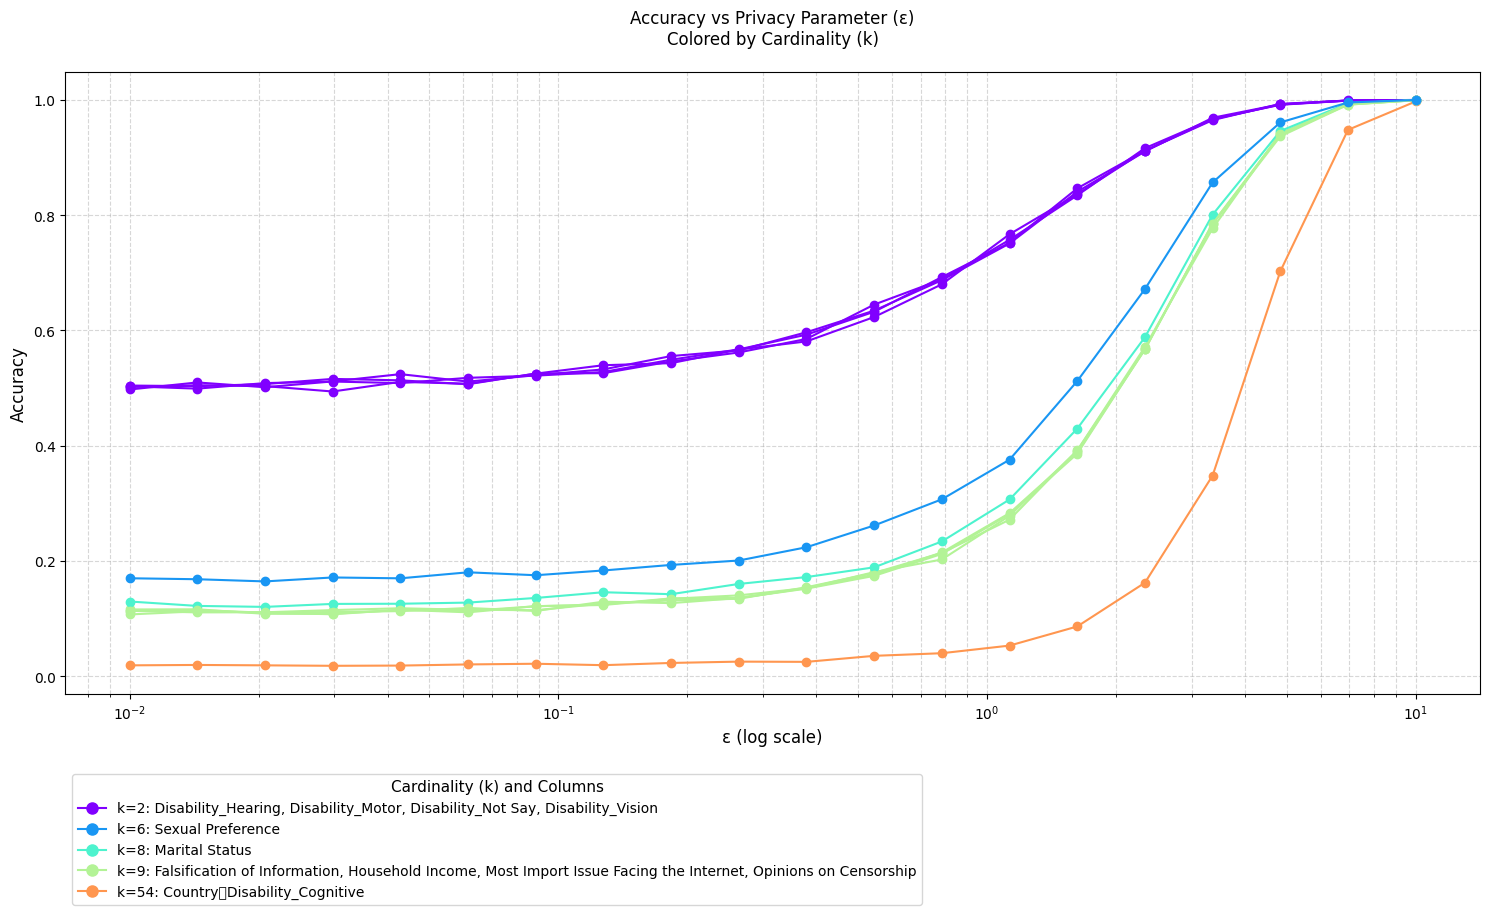

In [ ]:
epsilons=np.logspace(-2, 1, 20)
results = plot_accuracy_vs_epsilon(
    df,
    sensitive_columns,
    epsilons = epsilons
)

#### Observation:
- Privacy vs. Accuracy:
  - Higher ε (less privacy) → Higher truth probability (p) → Higher accuracy.
  - Lower ε (stronger privacy) → More randomization → Lower accuracy.

- Cardinality (k) Impact:
  - Lower k (fewer categories) → Higher p for the same ε → Higher accuracy
(e.g., Binary data (k=2) is easier to protect than 10-category data).
  - Higher k → Requires larger ε to maintain usable accuracy.


#### Conclusion:

Differential privacy via randomized response provides a mathematically rigorous way to trade accuracy for privacy in categorical data. The key levers are:

- Privacy parameter (ε): Controls the noise-accuracy balance.

- Cardinality (k): Determines how much noise is needed. Larger domains (larger 𝑘)require higher ε to preserve utility because the noise is more spread out.

By carefully selecting ε and preprocessing high-cardinality features, practitioners can achieve meaningful privacy guarantees while preserving data utility.

#### Sensitive attributes comparison after deplying DP

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


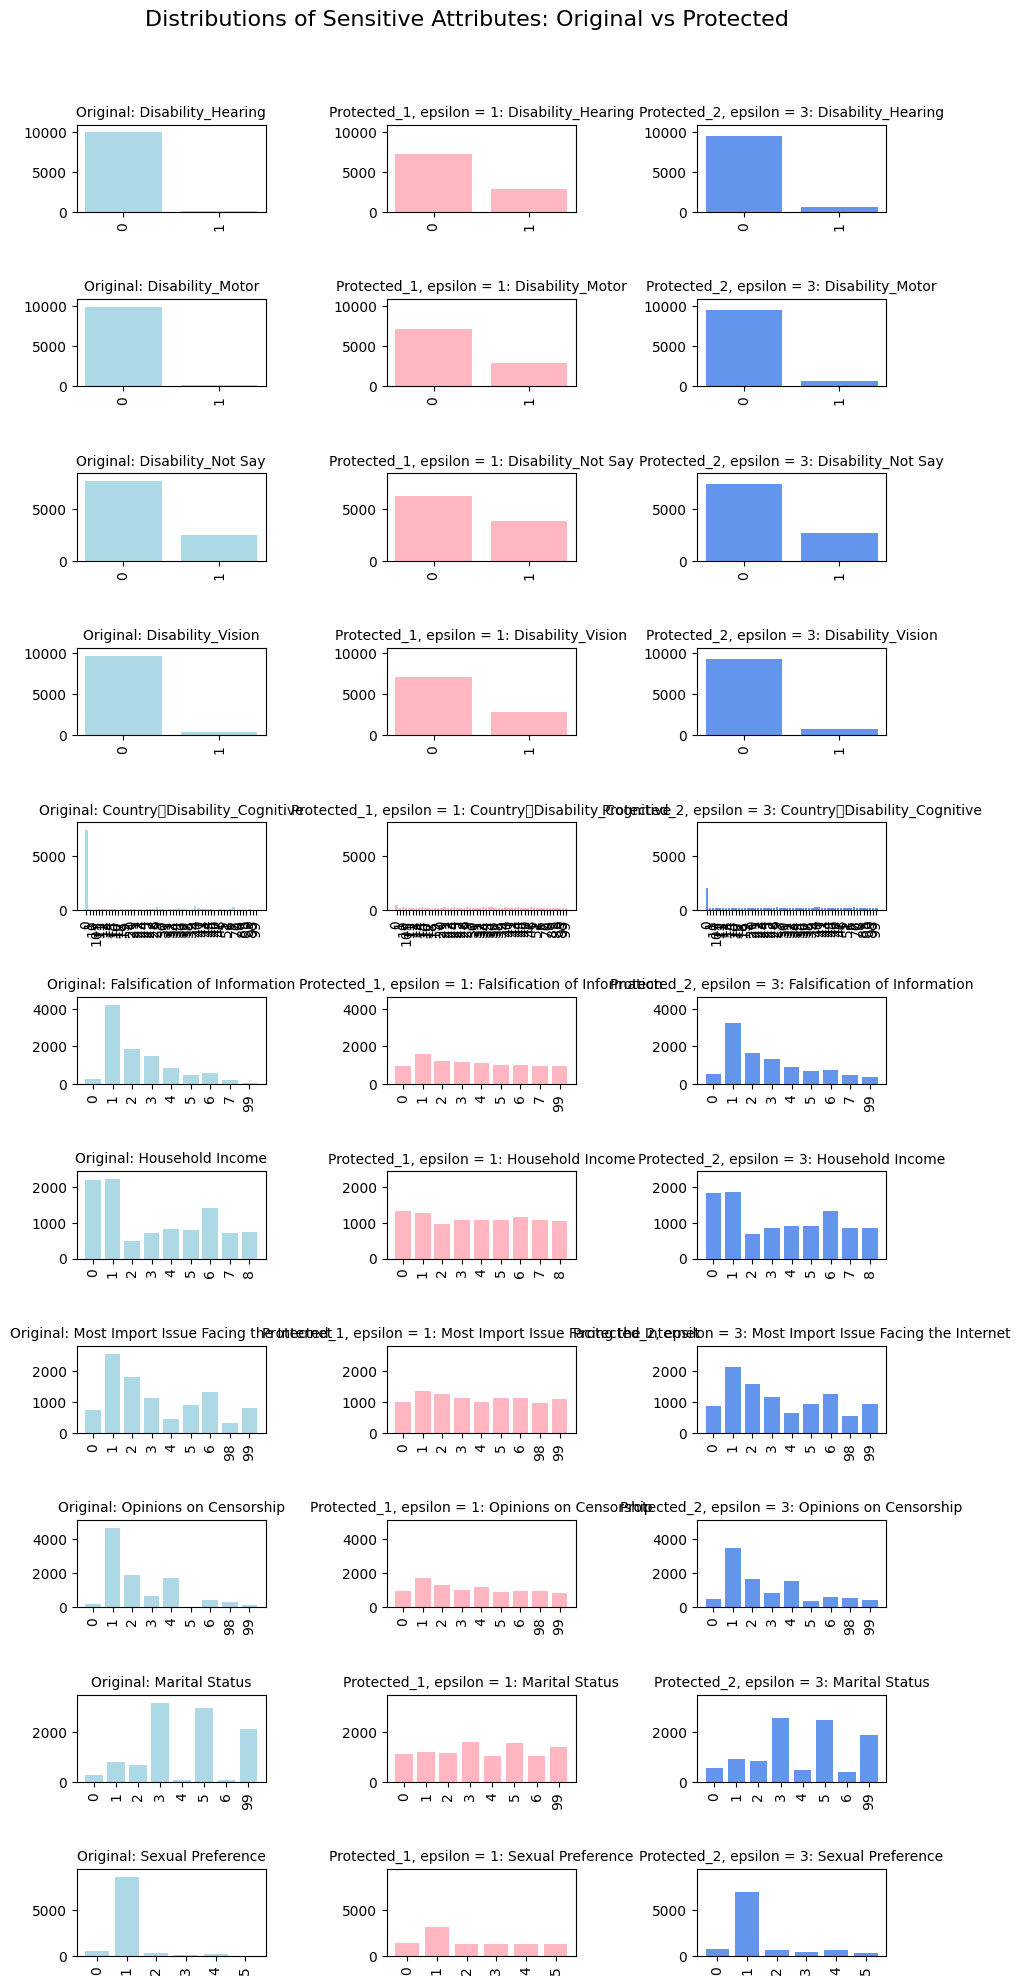

In [ ]:
fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(10, 20))
fig.tight_layout(pad=5)

for idx, col in enumerate(sensitive_columns):
    row = idx

    # Count distributions
    original_counts = df[col].value_counts().sort_index()
    protected_counts_1 = protected_df_1[col].value_counts().sort_index()
    protected_counts_2 = protected_df_2[col].value_counts().sort_index()
    # Determine common y-axis max
    max_y = max(original_counts.max(), protected_counts_1.max(), protected_counts_2.max()) * 1.1  # 10% padding

    # Original plot
    axes[row, 0].bar(original_counts.index.astype(str), original_counts.values, color='lightblue')
    axes[row, 0].set_title(f'Original: {col}', fontsize=10)
    axes[row, 0].set_ylim(0, max_y)
    axes[row, 0].tick_params(axis='x', rotation=90)

    # Protected plot, epsilon_1
    axes[row, 1].bar(protected_counts_1.index.astype(str), protected_counts_1.values, color='lightpink')
    axes[row, 1].set_title(f'Protected_1, epsilon = {epsilon_1}: {col}', fontsize=10)
    axes[row, 1].set_ylim(0, max_y)
    axes[row, 1].tick_params(axis='x', rotation=90)

    # Protected plot, epsilon_2
    axes[row, 2].bar(protected_counts_2.index.astype(str), protected_counts_2.values, color='cornflowerblue')
    axes[row, 2].set_title(f'Protected_2, epsilon = {epsilon_2}: {col}', fontsize=10)
    axes[row, 2].set_ylim(0, max_y)
    axes[row, 2].tick_params(axis='x', rotation=90)

plt.subplots_adjust(hspace=1)
plt.suptitle("Distributions of Sensitive Attributes: Original vs Protected", fontsize=16, y=1.02)
plt.show()


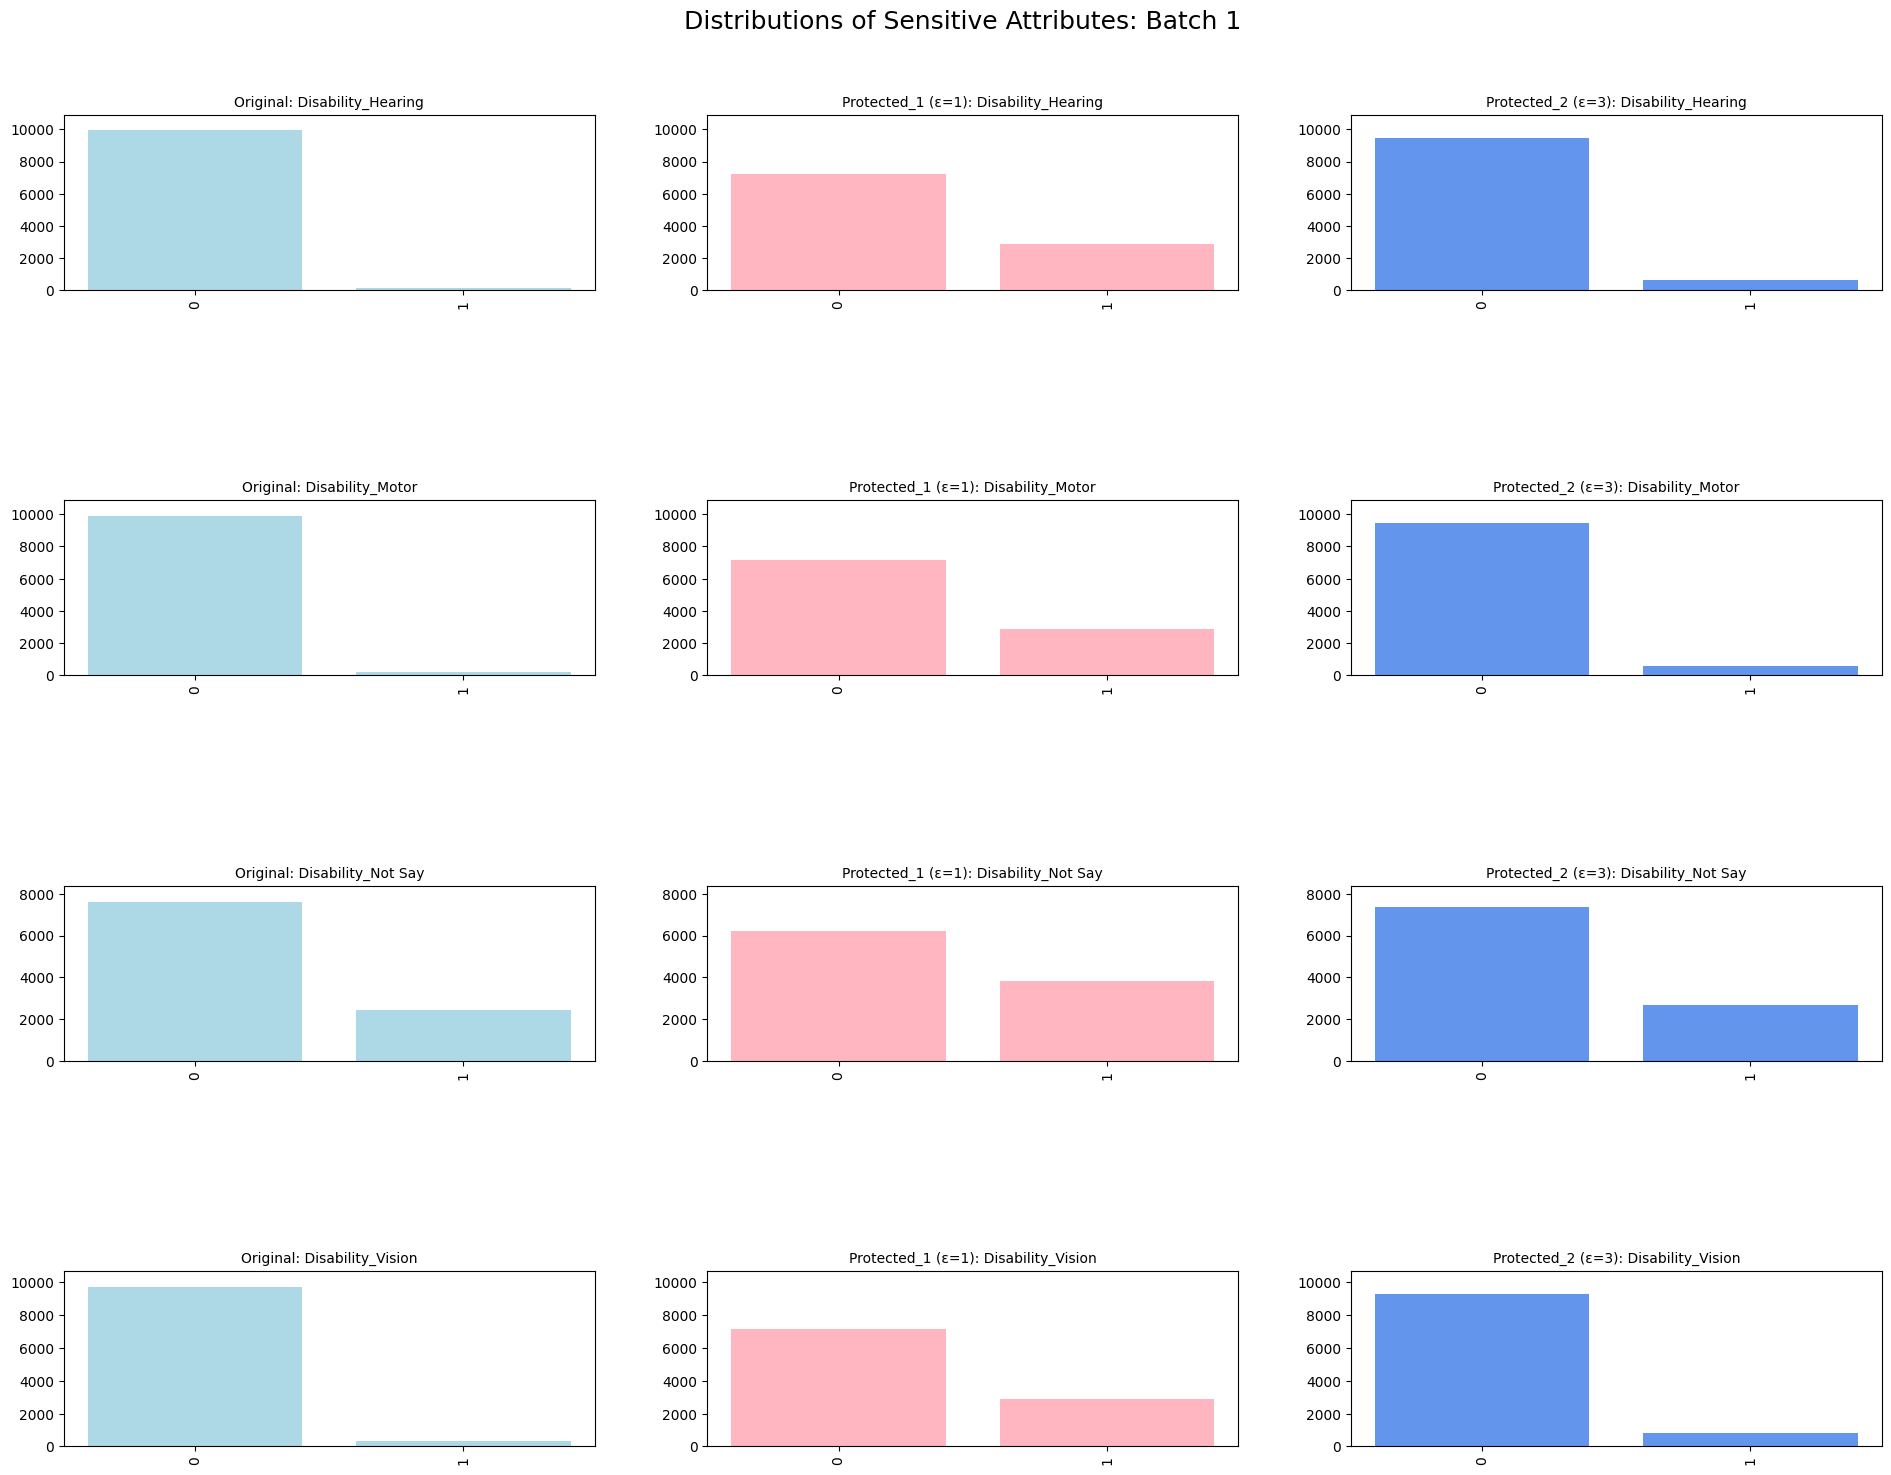

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


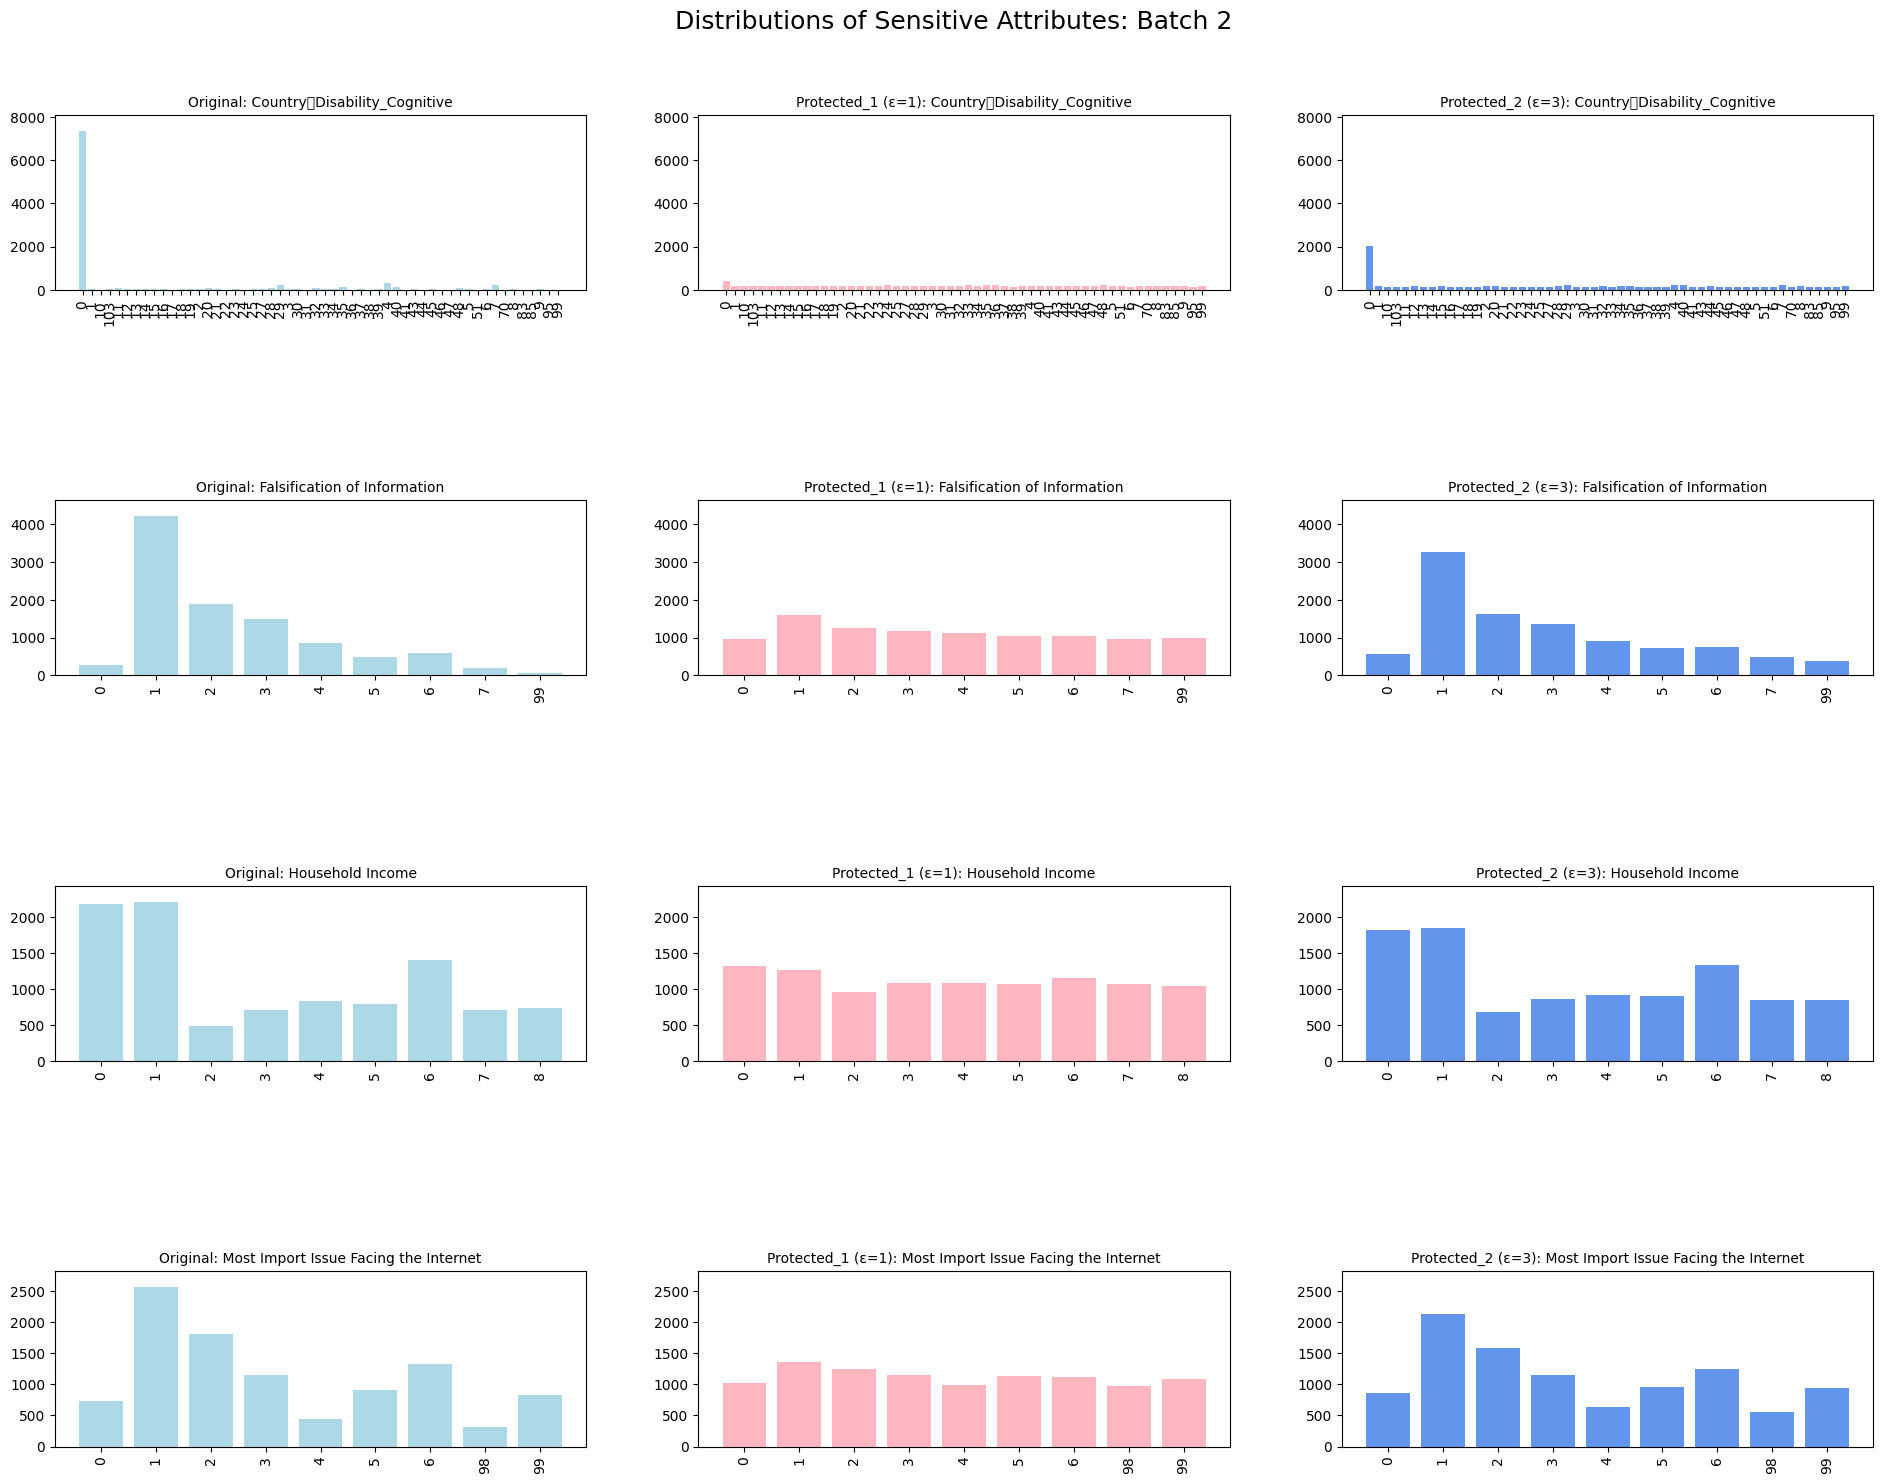

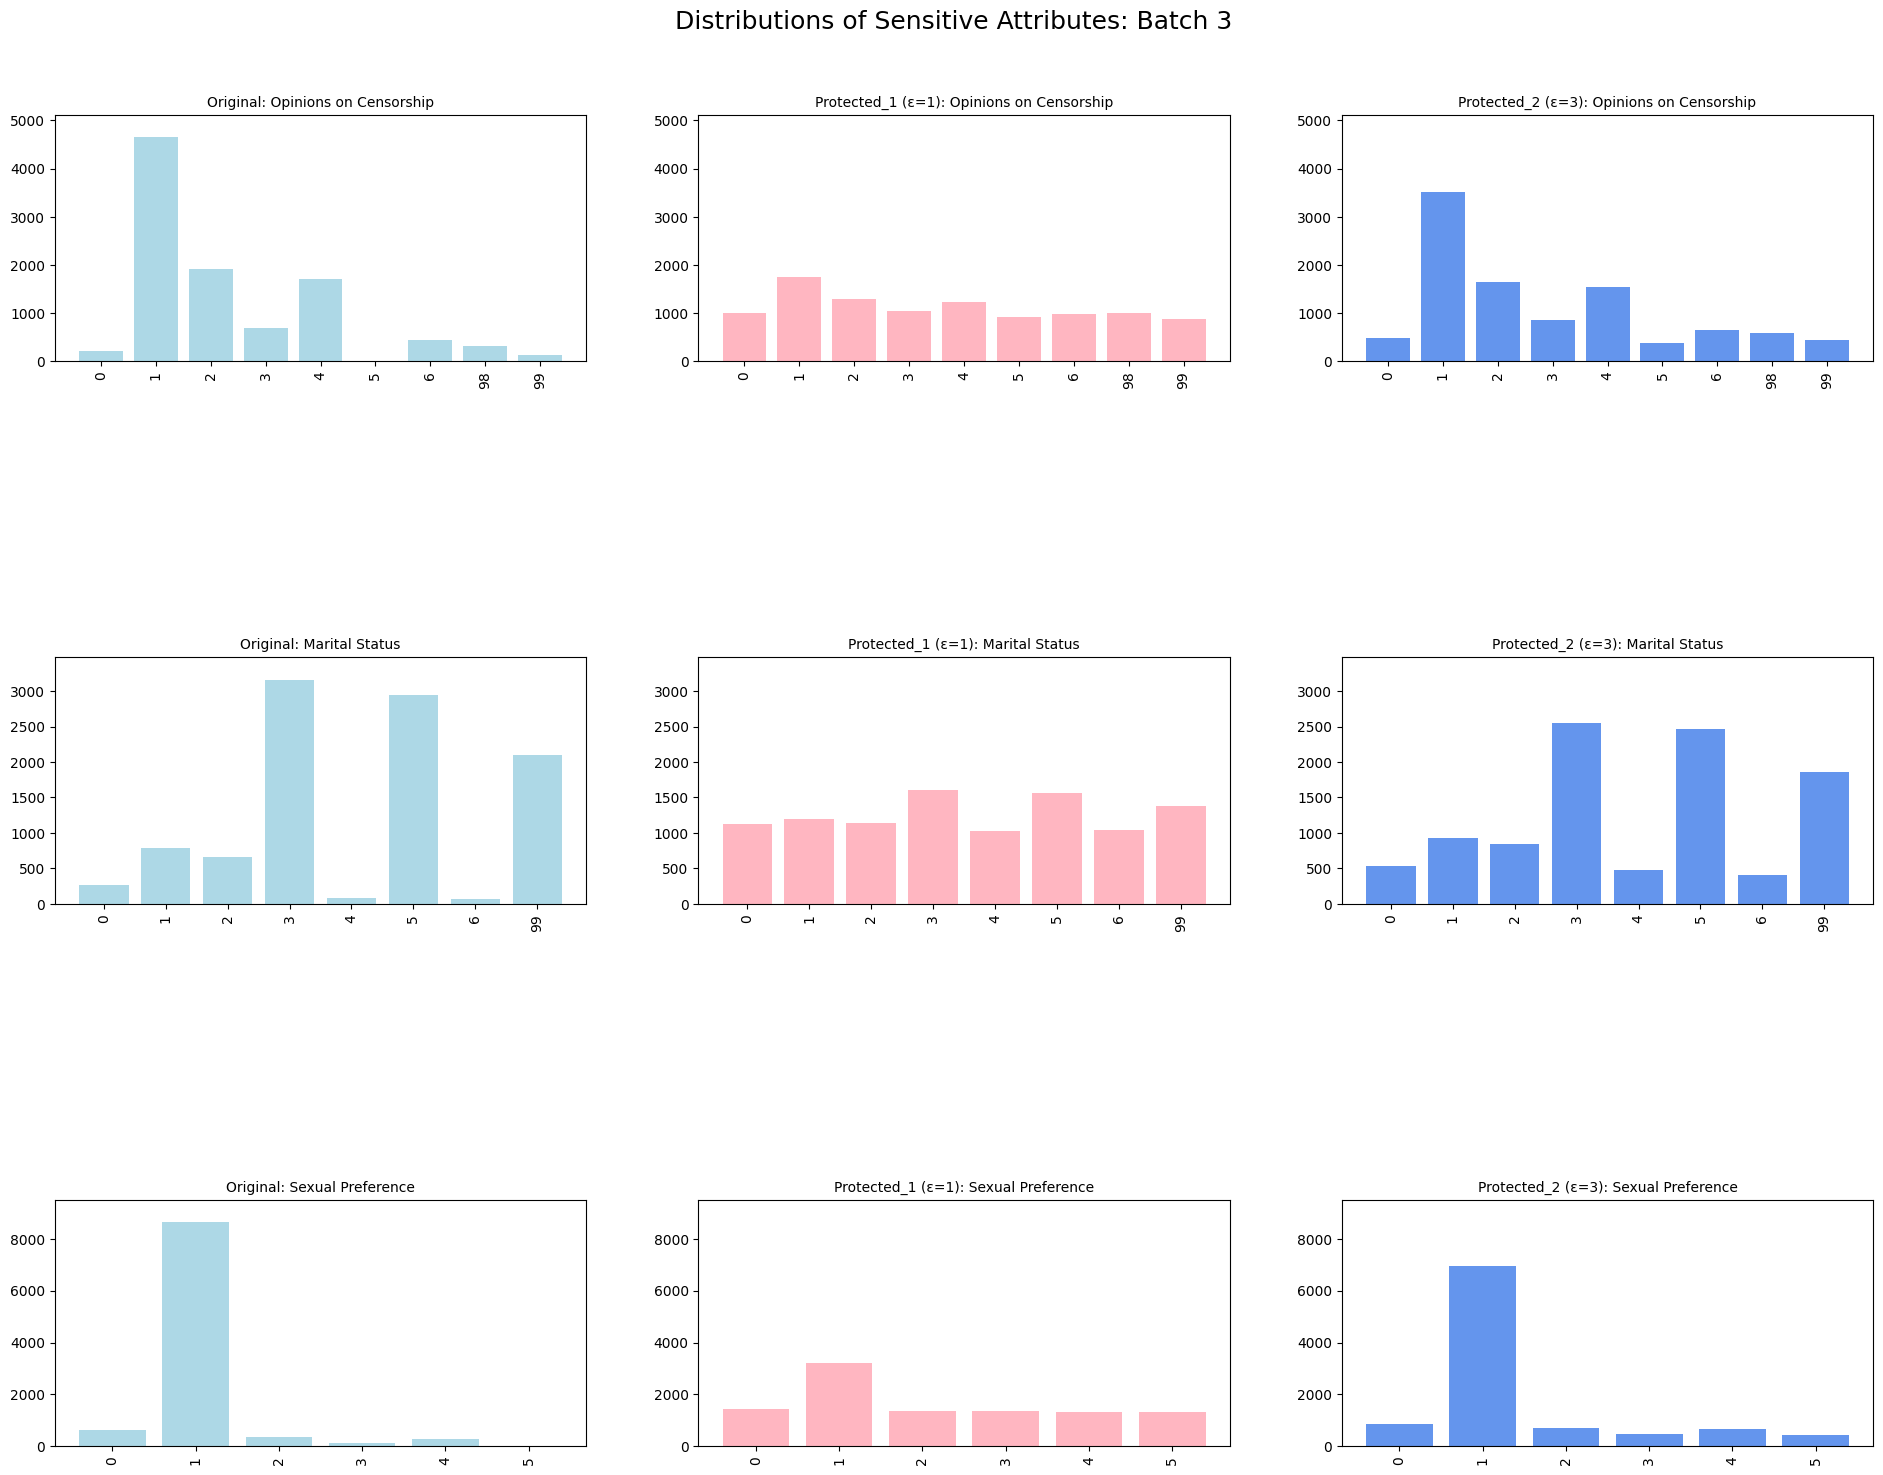

In [ ]:
# Split into batches | To put in slides
batches = [sensitive_columns[:4], sensitive_columns[4:8], sensitive_columns[8:]]

# Plot settings
ncols = 3
figsize = (20,15)

for batch_idx, batch in enumerate(batches):
    nrows = len(batch)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.tight_layout(pad=5)

    for row, col in enumerate(batch):
        # Count distributions
        original_counts = df[col].value_counts().sort_index()
        protected_counts_1 = protected_df_1[col].value_counts().sort_index()
        protected_counts_2 = protected_df_2[col].value_counts().sort_index()

        # Determine common y-axis max
        max_y = max(
            original_counts.max() if not original_counts.empty else 0,
            protected_counts_1.max() if not protected_counts_1.empty else 0,
            protected_counts_2.max() if not protected_counts_2.empty else 0
        ) * 1.1  # 10% padding

        # Plot Original
        axes[row, 0].bar(original_counts.index.astype(str), original_counts.values, color='lightblue')
        axes[row, 0].set_title(f'Original: {col}', fontsize=10)
        axes[row, 0].set_ylim(0, max_y)
        axes[row, 0].tick_params(axis='x', rotation=90)

        # Plot Protected_1
        axes[row, 1].bar(protected_counts_1.index.astype(str), protected_counts_1.values, color='lightpink')
        axes[row, 1].set_title(f'Protected_1 (ε={epsilon_1}): {col}', fontsize=10)
        axes[row, 1].set_ylim(0, max_y)
        axes[row, 1].tick_params(axis='x', rotation=90)

        # Plot Protected_2
        axes[row, 2].bar(protected_counts_2.index.astype(str), protected_counts_2.values, color='cornflowerblue')
        axes[row, 2].set_title(f'Protected_2 (ε={epsilon_2}): {col}', fontsize=10)
        axes[row, 2].set_ylim(0, max_y)
        axes[row, 2].tick_params(axis='x', rotation=90)

    plt.subplots_adjust(hspace=1.2)
    plt.suptitle(f"Distributions of Sensitive Attributes: Batch {batch_idx + 1}", fontsize=18, y=1.02)
    plt.show()
    plt.close(fig)  # Explicitly close the figure to avoid overlapping in some environments


##### Observation

With increasing epsilon, the distribution of sensitive attributes in protected data, starts resembling the original data, irrespective of column cardinality of attributes.